In [70]:

import os
import shutil
import math
import zipfile
import cv2
import dlib
import requests
import bz2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from icrawler.builtin import GoogleImageCrawler
from PIL import Image, ImageOps
import supervisely as sly
import pandas as pd  


In [93]:
current_dir = os.getcwd()
print("Текущая рабочая директория:", current_dir)

Текущая рабочая директория: /Users/kaledinaoa/Desktop/OneCell


# 1. Базовая работа с python/numpy

1. Скачайте 10-20 изображений с лицами из интернета какими удобно средствами (например)

2. Воспользуйтесь одним из готовых face-detector/face-landmark-detector для того, чтобы на выбранных изображениях найти лицо и ключевые точки на лице. Можно для этого взять связку библиотек OpenCV (opencv-python) & dlib (dlib-python). 

3. Результат детектирования лица (bbox) & landmarks (points) визуализировать в jupyter-notebook для первых 5-10 картинок. 
Для визуализации можно использовать matplotlib, например 🕷️


### Скачиваем изображения из Google

Испльзуем GoogleImageCrawler для загрузки

Переменная num_img_down используется для определения количества загружаемых изображений

In [24]:
# Папка для сохранения изображений
output_dir = 'data/trump_images'

num_img_down = 10

# Функция для удаления папки, если она существует
def remove_folder_if_exists(folder_path):
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
        print(f"Folder {folder_path} removed.")

remove_folder_if_exists(output_dir)

# Создание экземпляра GoogleImageCrawler и загрузка изображений
google_crawler = GoogleImageCrawler(storage={'root_dir': output_dir})
google_crawler.crawl(keyword='Donald Trump', max_num=num_img_down, min_size=(400, 400), max_size=None)

2024-06-25 12:31:25,263 - INFO - icrawler.crawler - start crawling...
2024-06-25 12:31:25,266 - INFO - icrawler.crawler - starting 1 feeder threads...
2024-06-25 12:31:25,275 - INFO - icrawler.crawler - starting 1 parser threads...
2024-06-25 12:31:25,280 - INFO - feeder - thread feeder-001 exit
2024-06-25 12:31:25,289 - INFO - icrawler.crawler - starting 1 downloader threads...


Folder data/trump_images removed.


2024-06-25 12:31:25,923 - INFO - parser - parsing result page https://www.google.com/search?q=Donald+Trump&ijn=0&start=0&tbs=&tbm=isch
2024-06-25 12:31:27,026 - INFO - downloader - image #1	https://upload.wikimedia.org/wikipedia/commons/5/56/Donald_Trump_official_portrait.jpg
2024-06-25 12:31:27,240 - INFO - downloader - image #2	https://hips.hearstapps.com/hmg-prod/images/former-u-s-president-donald-trump-speaks-to-reporters-news-photo-1680289458.jpg
2024-06-25 12:31:27,378 - INFO - downloader - image #3	https://cdn.britannica.com/31/149831-050-83A0E45B/Donald-J-Trump-2010.jpg
2024-06-25 12:31:27,574 - INFO - downloader - downloaded images reach max num, thread downloader-001 is ready to exit
2024-06-25 12:31:27,575 - INFO - downloader - thread downloader-001 exit
2024-06-25 12:31:28,042 - INFO - parser - downloaded image reached max num, thread parser-001 is ready to exit
2024-06-25 12:31:28,043 - INFO - parser - thread parser-001 exit
2024-06-25 12:31:28,311 - INFO - icrawler.crawle

Изменяем разрешение изображений чтобы привести их к одинаковому это поможет в изображении детектированных точек

In [25]:
def resize_image(image_path, target_size=400):
    with Image.open(image_path) as img:
        if img.height > img.width:
            # Вертикальное изображение
            new_height = target_size
            aspect_ratio = img.width / img.height
            new_width = int(target_size * aspect_ratio)
        else:
            # Горизонтальное изображение
            new_width = target_size
            aspect_ratio = img.height / img.width
            new_height = int(target_size * aspect_ratio)
        
        # Изменяем размер изображения с сохранением пропорций
        img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)
        img.save(image_path)

# Изменение размера всех загруженных изображений
for filename in os.listdir(output_dir):
    if filename.endswith(('.jpg', '.jpeg', '.png')):
        image_path = os.path.join(output_dir, filename)
        resize_image(image_path)

Переходим к модели по детектированию точек. Перед началом работы необходимо ее скачать в папку models

In [29]:
folder_path = "models"
file_model = "shape_predictor_68_face_landmarks.dat"

# Проверка существования папки models/
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print("Создана директория models/")

%cd models

# Проверка существования файла модели
if not os.path.exists(file_model):
    print(f"Скачиваем модель {file_model}")
    url = "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2"
    compressed_file_path = "shape_predictor_68_face_landmarks.dat.bz2"
    decompressed_file_path = file_model
    response = requests.get(url, stream=True)
    with open(compressed_file_path, "wb") as f:
        f.write(response.content)

    with bz2.open(compressed_file_path, "rb") as f_in, open(decompressed_file_path, "wb") as f_out:
        f_out.write(f_in.read())

    os.remove(compressed_file_path)
    print("Файл успешно скачан и распакован:", decompressed_file_path)
else:
    print(f"Модель {file_model} уже существует в папке models/")

%cd ..

/Users/kaledinaoa/Desktop/OneCell/models
Модель shape_predictor_68_face_landmarks.dat уже существует в папке models/
/Users/kaledinaoa/Desktop/OneCell


Создаем детектор и предиктор

In [26]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("models/shape_predictor_68_face_landmarks.dat")

Создаем функцию отрисовки 

In [27]:
def print_image(image, detector, image_file, i):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)

    for face in faces:
        x1 = face.left() 
        y1 = face.top()  
        x2 = face.right()
        y2 = face.bottom()
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 1)

        landmarks = predictor(gray, face)
        for n in range(0, 68):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            cv2.circle(image, (x, y), 1, (0, 255, 255), -1) 

    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Image {i}: {image_file}")
    plt.show()

Выбираем первые 5 изображений (можно больше/меньше в зависимости от переменной num_img_print)

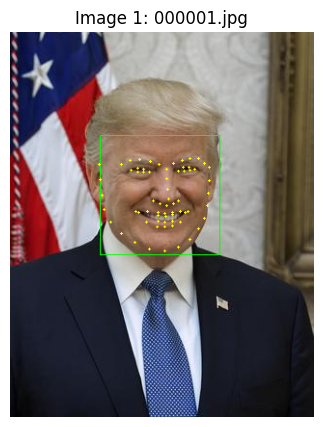

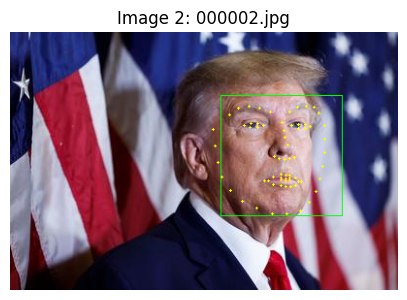

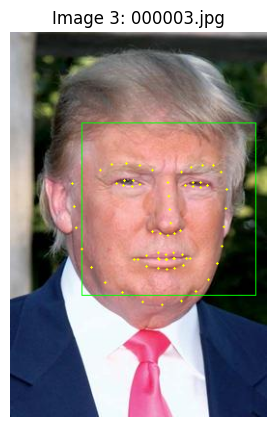

In [28]:
num_img_print = 5

image_dir = output_dir
image_files = sorted(os.listdir(image_dir))

for i, image_file in enumerate(image_files[:min(num_img_print,num_img_down)], start=1):
    image_path = os.path.join(image_dir, image_file)
    image = cv2.imread(image_path)

    if image is None:
        print(f"Skipping {image_file}. Image not loaded.")
        continue

    print_image(image, detector, image_file, i)


# 2. Оценка метрик и валидация моделей

1. Скачайте датасет с kaggle-соревнования Kaggle: Facial Keypoints Detection

2. Задетектируйте при помощи выбранного выше landmark-детектора точки на лицах из этого датасета

3. Посчитайте метрики для Ground-Truth точек которые эквивалентны точкам из модели (в opencv 68-point модель, в kaggle разметка для 15-точек).

4. Подумайте, предложите метрики, которые стоит посчитать для этой задачи. Мы хотим при помощи этих метрик оценить несколько факторов:
    - оценить точность детектирования каждой из точек и всех точек в среднем
    - оценить точность позиционирования (насколько точки смещаются относительно GT) для каждой landmark и в среднем

5. Отберите и визуализируйте (изображение + точки Ground Truth + Predicts) 3-5 изображений с самым высоким качеством детектирования и с самым низким.

### Импорт данных

#### Импорт данных из kaggle

%kaggle datasets download -d kaggle/facial-keypoints-detection -p data/kaggle/

1. Скачать ваш собственный токен с сайта kaggle

2. Cоздать папку .kaggle 

mkdir -p ~/.kaggle

3. перенести его из загрузок в папку .kaggle

mv ~/Downloads/kaggle.json ~/.kaggle/kaggle.json

In [55]:
# Не получилось скачать датасет напрямую
# Нужно скачать в папку output_dir = 'data/kaggle/'

from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

dataset_name_or_url = 'facial-keypoints-detection'
output_dir = 'data/kaggle/'

# Cкачиваем датасет в папку data/kaggle/
# api.dataset_download_files(dataset_name_or_url, path=output_dir, unzip=True)

In [68]:
# Разархимируем и разложим все удобно

name_subfolder = "input/"
current_dir = "data/kaggle/facial-keypoints-detection/"
target_subfolder=f"{current_dir}{name_subfolder}"

if not os.path.exists(target_subfolder):
    os.makedirs(target_subfolder)

files = [file for file in os.listdir(current_dir) if os.path.isfile(os.path.join(current_dir, file))]

for file in files:
    file_path = os.path.join(current_dir, file)
    target_file_path = os.path.join(target_subfolder, file)
    shutil.move(file_path, target_file_path)

with zipfile.ZipFile(f"{target_subfolder}training.zip", "r") as zip_ref:
    zip_ref.extractall(f"{current_dir}working/")

with zipfile.ZipFile(f"{target_subfolder}test.zip", "r") as zip_ref:
    zip_ref.extractall(f"{current_dir}working/")

### перейдем к данным

In [71]:
train_df = pd.read_csv(f"{current_dir}working/training.csv")
test_df = pd.read_csv(f"{current_dir}working/test.csv")

In [74]:
# Используем прошлую модель
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("models/shape_predictor_68_face_landmarks.dat")

def str_to_image(str_img):
    return np.array(str_img.split(), dtype=np.uint8).reshape(96, 96)

train_df['Image'] = train_df['Image'].apply(str_to_image)
test_df['Image'] = test_df['Image'].apply(str_to_image)

In [75]:
# Cоздаем словарь детектированных точек
def detect_landmarks(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    if len(faces) > 0:
        face = faces[0]
        landmarks = predictor(gray, face)
        model_68_points_dict = {
            'left_eye_center': ((landmarks.part(42).x + landmarks.part(45).x) // 2, (landmarks.part(42).y + landmarks.part(45).y) // 2),
            'right_eye_center': ((landmarks.part(36).x + landmarks.part(39).x) // 2, (landmarks.part(36).y + landmarks.part(39).y) // 2),
            'left_eye_inner_corner': (landmarks.part(42).x, landmarks.part(42).y),
            'left_eye_outer_corner': (landmarks.part(45).x, landmarks.part(45).y),
            'right_eye_inner_corner': (landmarks.part(39).x, landmarks.part(39).y),
            'right_eye_outer_corner': (landmarks.part(36).x, landmarks.part(36).y),
            'left_eyebrow_inner_end': (landmarks.part(22).x, landmarks.part(22).y),
            'left_eyebrow_outer_end': (landmarks.part(26).x, landmarks.part(26).y),
            'right_eyebrow_inner_end': (landmarks.part(21).x, landmarks.part(21).y),
            'right_eyebrow_outer_end': (landmarks.part(17).x, landmarks.part(17).y),
            'nose_tip': (landmarks.part(30).x, landmarks.part(30).y),
            'mouth_left_corner': (landmarks.part(54).x, landmarks.part(54).y),
            'mouth_right_corner': (landmarks.part(48).x, landmarks.part(48).y),
            'mouth_center_top_lip': (landmarks.part(51).x, landmarks.part(51).y),
            'mouth_center_bottom_lip': (landmarks.part(57).x, landmarks.part(57).y)
        }
        return model_68_points_dict
    return []


# Cоздаем словарь тестовых точек
def get_ground_truth_points(row):
    true_points_dict = {}
    for column in train_df.columns:
        if column.endswith('_x'):
            key = column[:-2] 
            x_value = row[column]
            y_column = column[:-2] + '_y'
            y_value = row[y_column]
            true_points_dict[key] = (x_value, y_value)
    return true_points_dict

In [89]:
prediction = {}
my_metric = {}

for i in range(1,train_df['Image'].count()):
    sample_image = cv2.cvtColor(train_df.iloc[i]['Image'], cv2.COLOR_BGR2RGB)

    true_points_dict = get_ground_truth_points(train_df.iloc[i])
    detected_points_dict = detect_landmarks(sample_image)

    difference_dict = {}

    for key in true_points_dict.keys():
        if key in detected_points_dict:
            true_x, true_y = true_points_dict[key]
            detected_x, detected_y = detected_points_dict[key]
            # Евклидово расстояние
            difference_dict[key] = [true_x, detected_x, true_y, detected_y]
            difference_dict[key].append((true_x - detected_x,true_y - detected_y))
            difference_dict[key].append(math.sqrt((true_x - detected_x)**2 + (true_y - detected_y)**2))
            
            prediction[i] = pd.DataFrame.from_dict(difference_dict, orient='index', columns=['true_x','detected_x','true_y','detected_y','DiffCoord', 'Evklid'])
            my_metric[i] = prediction[i].Evklid.sum() // prediction[i].Evklid.count()


/var/folders/hd/zdtz4s_96nq3_p8__37vjsvh0000gn/T/ipykernel_5739/2394003195.py:22: RuntimeWarning: invalid value encountered in scalar floor_divide
  my_metric[i] = prediction[i].Evklid.sum() // prediction[i].Evklid.count()


In [90]:
# Визуализация детектированных точек
def visualize_prediction(image, pred_df):
    for index, row in pred_df.iterrows():
        true_x = row["true_x"]
        true_y = row["true_y"]
        detected_x = row["detected_x"]
        detected_y = row["detected_y"]

        # Проверяем, что значения не NaN 
        if not np.isnan(true_x) and not np.isnan(true_y):
            cv2.circle(image, (int(true_x), int(true_y)), 1, (0, 255, 0), -1) # зеленые

        if not np.isnan(detected_x) and not np.isnan(detected_y):
            cv2.circle(image, (int(detected_x), int(detected_y)), 1, (0, 0, 255), -1)   # красные

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

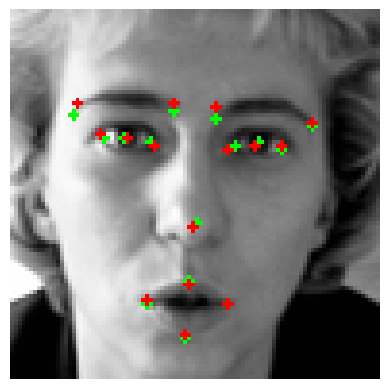

,true_x,detected_x,true_y,detected_y,DiffCoord,Evklid
left_eye_center,64.332936,63,34.970077,35,"(1.3329361702, -0.029923404299999845)",1.333272
right_eye_center,29.949277,30,33.448715,33,"(-0.05072340430000111, 0.4487148935999983)",0.451573
left_eye_inner_corner,58.856170,56,35.274349,36,"(2.856170212800002, -0.7256510638000009)",2.946910
left_eye_outer_corner,70.722723,70,36.187166,35,"(0.7227234042999982, 1.1871659573999978)",1.389853
right_eye_inner_corner,36.034723,37,34.361532,35,"(-0.9652765956999971, -0.6384680851000013)",1.157325
right_eye_outer_corner,24.472511,23,33.144443,32,"(1.472510638300001, 1.144442553200001)",1.864949
left_eyebrow_inner_end,53.987404,53,28.275949,25,"(0.9874042552999995, 3.275948936199999)",3.421521
left_eyebrow_outer_end,78.634213,78,30.405923,29,"(0.6342127660000045, 1.405923404300001)",1.542351
right_eyebrow_inner_end,42.728851,42,26.146043,24,"(0.7288510638000005, 2.146042553200001)",2.266434
right_eyebrow_outer_end,16.865362,17,27.058860,24,"(-0.13463829790000048, 3.0588595745000013)",3.061821


In [91]:
# ВЫБЕРИ ФОТО
pic = 1

sample_image = cv2.cvtColor(train_df.iloc[pic]['Image'], cv2.COLOR_BGR2RGB)
visualize_prediction(sample_image, prediction[pic])
prediction[pic]

In [79]:
def print_top(top):
    for pic, value in top:
        print(f"image {pic}: {value}")
        sample_image = cv2.cvtColor(train_df.iloc[pic]['Image'], cv2.COLOR_BGR2RGB)
        visualize_prediction(sample_image, prediction[pic])

### Наихудшее качество детектирования

Как видно из изображений - наихудший результат детектирования не говорит о проблеме в модели, а показывает, что у нас могут быть неверные тестовые данные.

In [87]:
num_top = 10

image 1907: 39.72702738990525


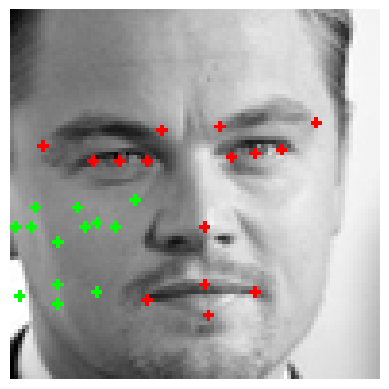

image 1877: 33.71235701276306


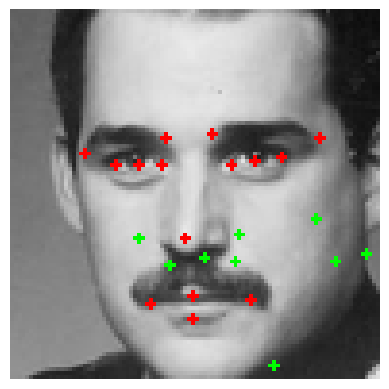

image 2199: 22.454035451877765


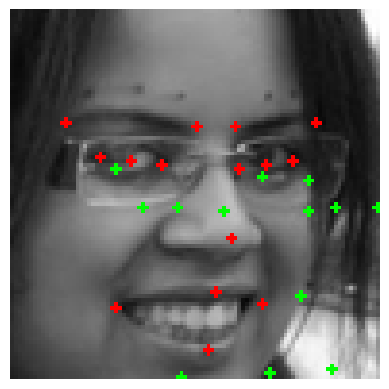

image 5933: 20.883161989666917


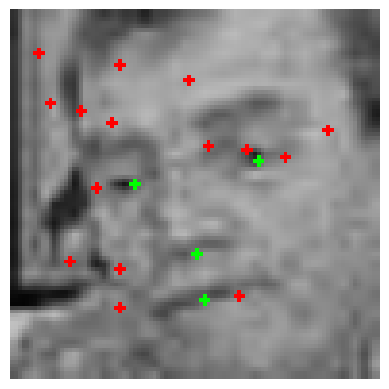

image 1953: 16.83310343667811


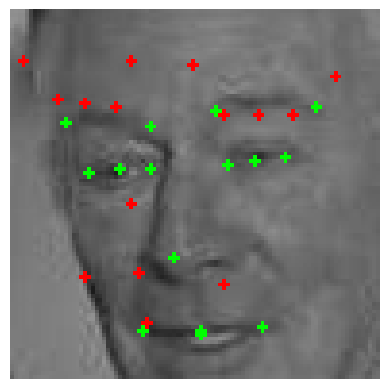

image 1747: 14.797587654491654


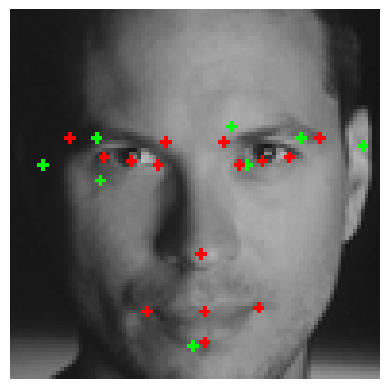

image 6873: 14.330731267934562


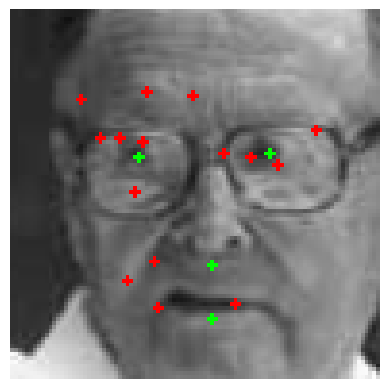

image 5653: 13.563474297524426


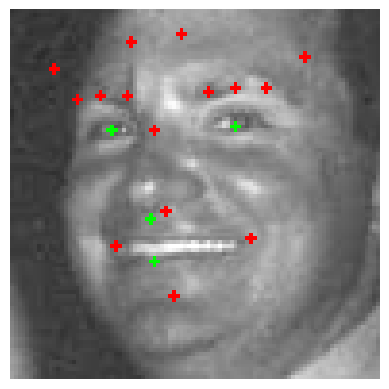

image 4200: 13.31893866240023


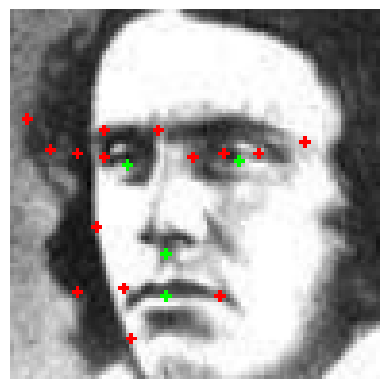

image 2739: 13.267404182315502


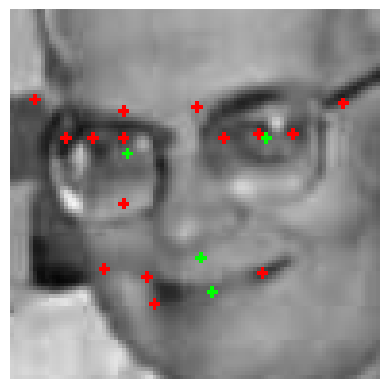

In [88]:
top_worst_detection = sorted(my_metric.items(), key=lambda x: x[1], reverse=True)[:num_top]
print_top(top_worst_detection)

### Наилучшее качество детектирования

image 1259: 0.9799947114054232


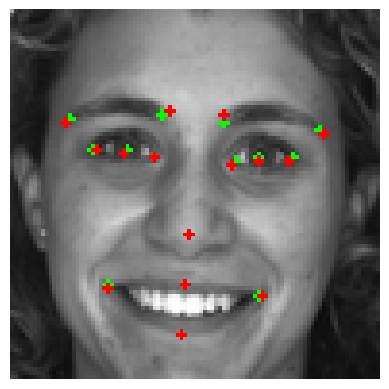

image 1566: 1.032893671107836


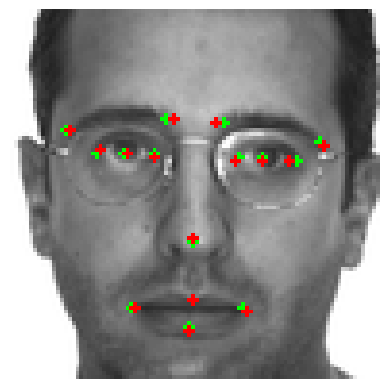

image 2125: 1.043057013659586


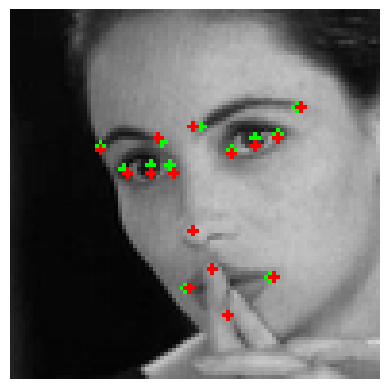

In [85]:
top_best_detection = sorted(my_metric.items(), key=lambda x: x[1], reverse=False)[:num_top]
print_top(top_best_detection)

# 3. Работа с инструментами разметки

Мы видим, что модель некоторые точки неверно детектирует на скачанных нами лицах и мы хотим отправить эти данные на разметку человеком. Для этого мы хотим в инструмент для разметки данных загрузить изображения и предсказания модели для последующего исправления людьми. Соответственно в этом задании нужно:

1. завести если нет аккаунт на сервисе supervisely

2. почитать документацию и разобраться с SDK/Python-API для supervisely

3. написать код для загрузки данных в supervisely (в этом же jupyter-notebook)

4. загрузить 5-10 изображений и предсказаний модели в supervisely и вставить скриншот с работающего сервиса

5. замерьте скорость разметки и оцените время разметки с нуля и время доразметки результатов работы модели


In [94]:
# Токен находится в папке tokens с названием supervisely.txt
api_token = ""
address = ???
api = sly.Api(address, api_token)

# Создание проекта и датасета
workspace_name = 'your_workspace'
project_name = 'your_project'
project = api.project.create(workspace_name, project_name)
dataset_name = 'your_dataset'
dataset = api.dataset.create(project.id, dataset_name)

# Загрузка разметки из файла (например, COCO)
annotation_path = '/path/to/annotations.json'
sly.io.import_annotations_from_json(dataset.id, annotation_path)

# Закрытие проекта
api.project.close(project.id)